In [1]:
# For Data Handling
import pandas as pd
import numpy as np

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# ML Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Model Evaluation
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

# For Selection & Tuning of models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RepeatedKFold, cross_val_score, learning_curve

# For Feature Selection
from sklearn.feature_selection import mutual_info_regression

#For Warnings
import warnings


In [2]:
# For loading the dataset
df = pd.read_csv("/content/air_quality_health_impact_data.csv")
df.head()

,RecordID,AQI,PM10,PM2_5,NO2,SO2,O3,Temperature,Humidity,WindSpeed,RespiratoryCases,CardiovascularCases,HospitalAdmissions,HealthImpactScore,HealthImpactClass
0,1,187.270059,295.853039,13.038560,6.639263,66.161150,54.624280,5.150335,84.424344,6.137755,7,5,1,97.244041,0.0
1,2,475.357153,246.254703,9.984497,16.318326,90.499523,169.621728,1.543378,46.851415,4.521422,10,2,0,100.000000,0.0
2,3,365.996971,84.443191,23.111340,96.317811,17.875850,9.006794,1.169483,17.806977,11.157384,13,3,0,100.000000,0.0
3,4,299.329242,21.020609,14.273403,81.234403,48.323616,93.161033,21.925276,99.473373,15.302500,8,8,1,100.000000,0.0
4,5,78.009320,16.987667,152.111623,121.235461,90.866167,241.795138,9.217517,24.906837,14.534733,9,0,1,95.182643,0.0


In [3]:
# To Drop the null values
df.dropna(inplace=True)
df = df.select_dtypes(include=[np.number])

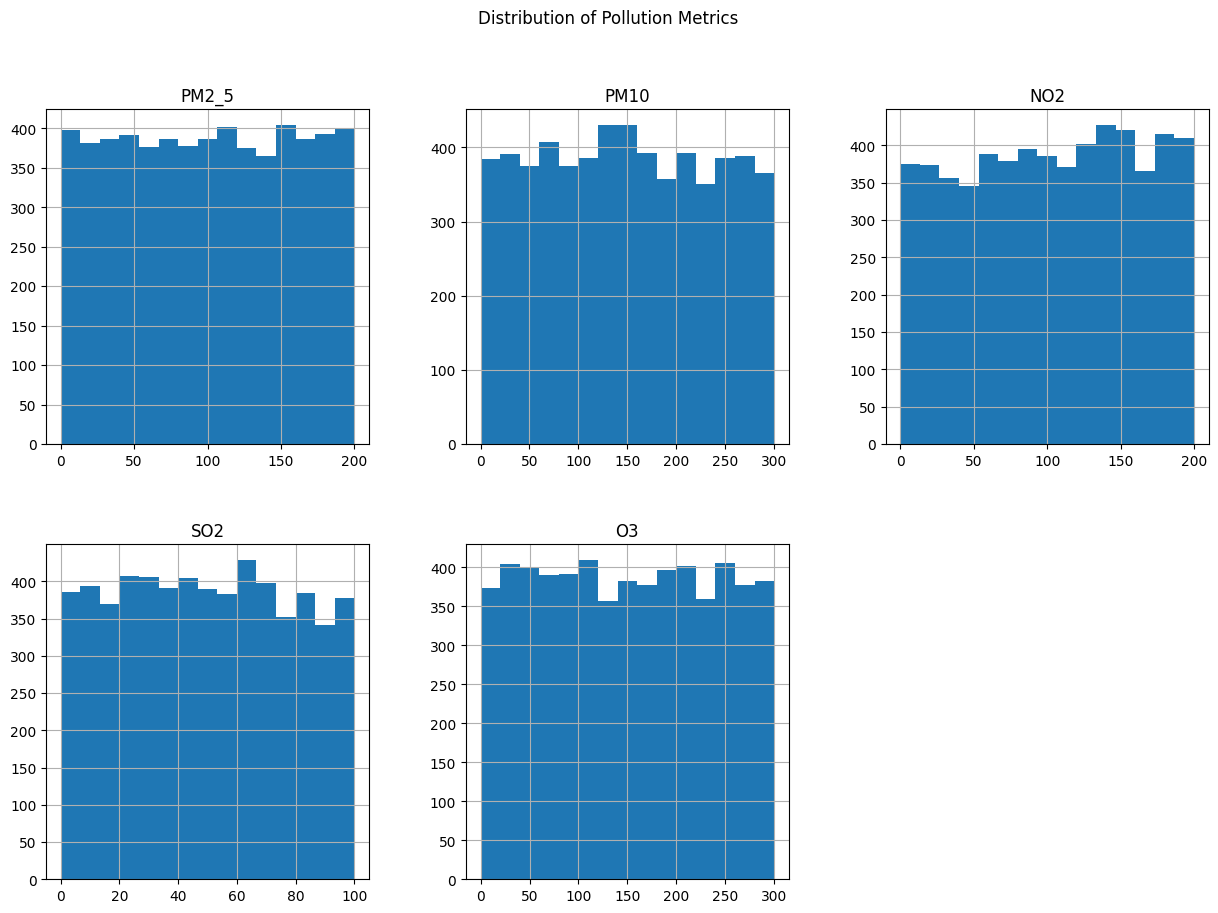

In [4]:
# Distribution of Pollution Metrics across Ranges
pollution_cols = ["PM2_5", "PM10", "NO2", "SO2", "O3"]
df[pollution_cols].hist(bins=15, figsize=(15, 10), layout=(2, 3))
plt.suptitle("Distribution of Pollution Metrics")
plt.show()

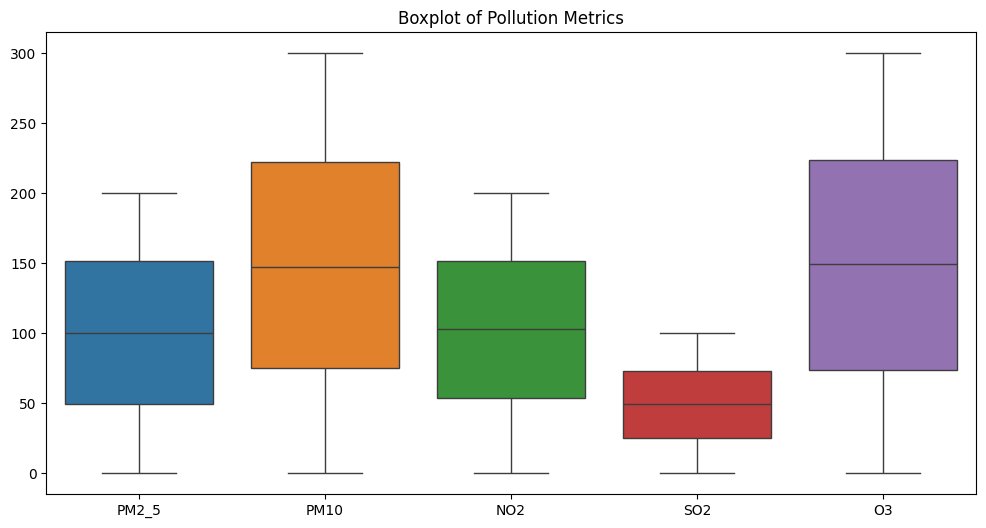

In [5]:
# Detection of outliers and spread in pollution metrics
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[pollution_cols])
plt.title("Boxplot of Pollution Metrics")
plt.show()

In [6]:
# Setting features and target
X = df.drop(columns=["RecordID", "HealthImpactScore", "HealthImpactClass"])
y = df["HealthImpactScore"]

# Computing Mutual Information
mi_scores = mutual_info_regression(X, y, random_state=42)

# Creating a pandas Series of MI scores
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

# Displaying sorted MI scores
print("Mutual Information Scores:")
print(mi_series)

# Selecting top features
selected_features_mi = mi_series[mi_series > 0].index.tolist()
print("\nSelected Features based on Mutual Information:")
print(selected_features_mi)


Mutual Information Scores:
AQI                    0.409174
PM2_5                  0.027918
HospitalAdmissions     0.022460
PM10                   0.020487
O3                     0.010492
CardiovascularCases    0.007880
NO2                    0.003140
WindSpeed              0.001888
Humidity               0.000000
Temperature            0.000000
SO2                    0.000000
RespiratoryCases       0.000000
dtype: float64

Selected Features based on Mutual Information:
['AQI', 'PM2_5', 'HospitalAdmissions', 'PM10', 'O3', 'CardiovascularCases', 'NO2', 'WindSpeed']


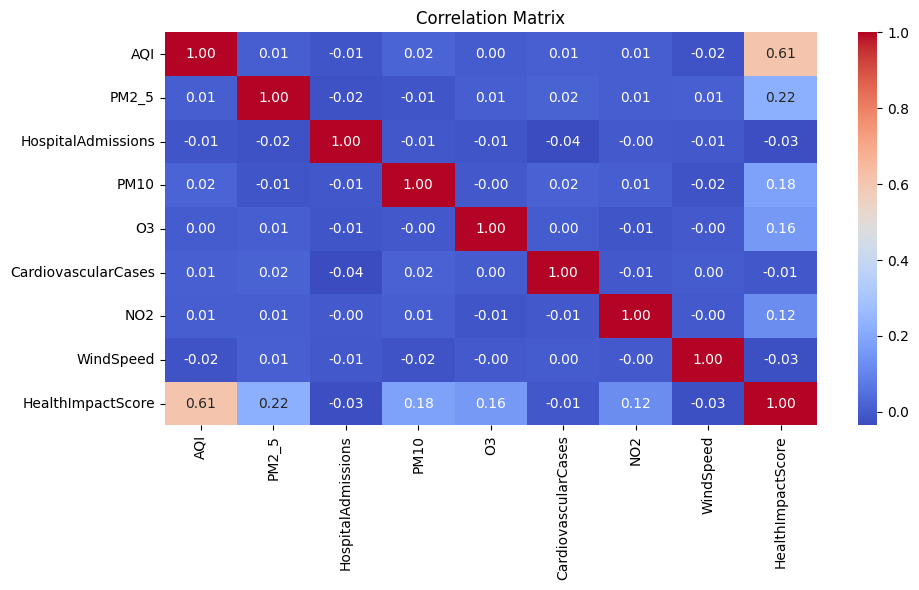


Highly Correlated Feature Pairs
None found


In [7]:
# Adding target back to selected features
corr_df = df[selected_features_mi + ["HealthImpactScore"]]

# Computing correlation matrix
corr_matrix = corr_df.corr()

# To Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# Identifying and listing high inter-feature correlations
high_corr_pairs = []
for i in range(len(selected_features_mi)):
    for j in range(i + 1, len(selected_features_mi)):
        corr_val = corr_matrix.loc[selected_features_mi[i], selected_features_mi[j]]
        if abs(corr_val) > 0.9:
            high_corr_pairs.append((selected_features_mi[i], selected_features_mi[j], corr_val))

print("\nHighly Correlated Feature Pairs")
print(high_corr_pairs if high_corr_pairs else "None found")


In [8]:
selected_features = ["AQI", "PM2_5", "PM10", "HospitalAdmissions", "O3", "CardiovascularCases"]
target = "HealthImpactScore"

# Preparing X and y
X = df[selected_features]
y = df[target]

# Train-test splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# 2. Random Forest Regressor
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# 3. XGBoost Regressor
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Results:")
    print(f"R² Score: {r2_score(y_true, y_pred):.4f}")
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"RMSE: {rmse:.4f}")

# Evaluating all models
evaluate_model("Linear Regression", y_test, y_pred_lr)
evaluate_model("Random Forest", y_test, y_pred_rf)
evaluate_model("XGBoost", y_test, y_pred_xgb)


Linear Regression Results:
R² Score: 0.4918
RMSE: 9.7577

Random Forest Results:
R² Score: 0.9247
RMSE: 3.7565

XGBoost Results:
R² Score: 0.9211
RMSE: 3.8448


Repeated K-Fold Results for Linear Regression:
Epoch 1/25: R² = 0.4918 | RMSE = 9.7577
Epoch 2/25: R² = 0.4651 | RMSE = 9.5175
Epoch 3/25: R² = 0.4773 | RMSE = 9.3429
Epoch 4/25: R² = 0.4686 | RMSE = 9.8524
Epoch 5/25: R² = 0.4830 | RMSE = 9.6440
Epoch 6/25: R² = 0.4781 | RMSE = 9.6819
Epoch 7/25: R² = 0.4648 | RMSE = 9.6410
Epoch 8/25: R² = 0.4929 | RMSE = 9.6498
Epoch 9/25: R² = 0.4185 | RMSE = 9.3133
Epoch 10/25: R² = 0.5092 | RMSE = 9.8942
Epoch 11/25: R² = 0.4735 | RMSE = 9.3475
Epoch 12/25: R² = 0.4636 | RMSE = 8.9353
Epoch 13/25: R² = 0.4718 | RMSE = 10.4381
Epoch 14/25: R² = 0.4782 | RMSE = 9.4455
Epoch 15/25: R² = 0.4903 | RMSE = 9.9313
Epoch 16/25: R² = 0.4834 | RMSE = 9.6348
Epoch 17/25: R² = 0.4623 | RMSE = 9.5153
Epoch 18/25: R² = 0.4788 | RMSE = 9.9426
Epoch 19/25: R² = 0.4746 | RMSE = 9.3962
Epoch 20/25: R² = 0.4865 | RMSE = 9.6378
Epoch 21/25: R² = 0.4854 | RMSE = 9.7536
Epoch 22/25: R² = 0.4583 | RMSE = 9.6254
Epoch 23/25: R² = 0.4420 | RMSE = 9.6428
Epoch 24/25: R² = 

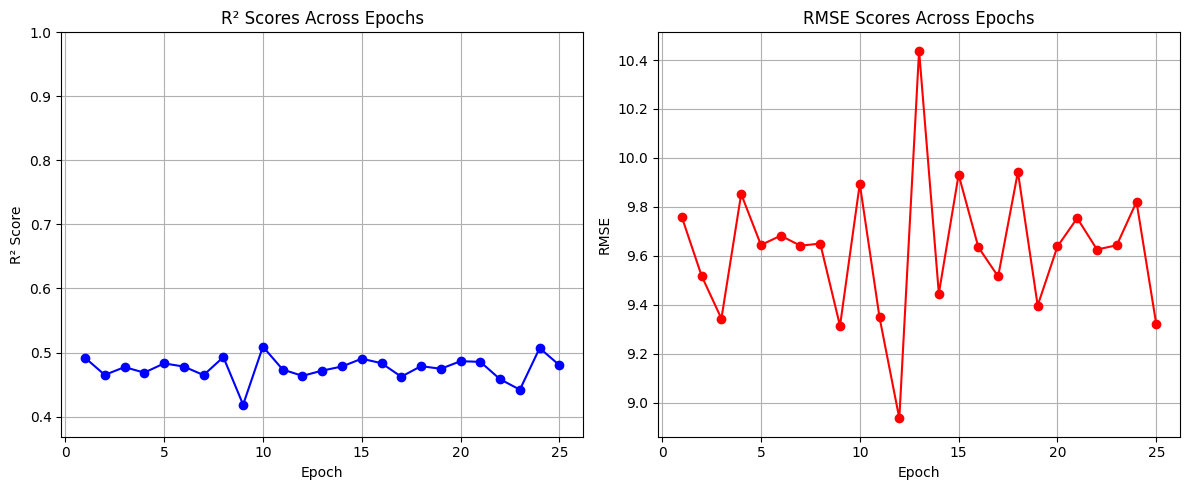

In [9]:
features = ["AQI", "PM2_5", "PM10", "HospitalAdmissions", "O3", "CardiovascularCases"]
target = "HealthImpactScore"

X = df[features].values
y = df[target].values

# Initializing model
model = LinearRegression()

#Doing Repeated K-Fold Cross-Validation
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

r2_scores = []
rmse_scores = []

print("Repeated K-Fold Results for Linear Regression:")

for epoch, (train_index, test_index) in enumerate(rkf.split(X), start=1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    r2_scores.append(r2)
    rmse_scores.append(rmse)

    print(f"Epoch {epoch}/25: R² = {r2:.4f} | RMSE = {rmse:.4f}")

# Summary for printout
print("\nSummary:")
print(f"R² Mean: {np.mean(r2_scores):.4f} | Std: {np.std(r2_scores):.4f}")
print(f"RMSE Mean: {np.mean(rmse_scores):.4f} | Std: {np.std(rmse_scores):.4f}")

# Results of Plotting
epochs = np.arange(1, 26)

plt.figure(figsize=(12, 5))

# Plotting R^2
plt.subplot(1, 2, 1)
plt.plot(epochs, r2_scores, marker='o', linestyle='-', color='b')
plt.title("R² Scores Across Epochs")
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.grid(True)
plt.ylim([min(r2_scores) - 0.05, 1])

# Plotting RMSE
plt.subplot(1, 2, 2)
plt.plot(epochs, rmse_scores, marker='o', linestyle='-', color='r')
plt.title("RMSE Scores Across Epochs")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid(True)

plt.tight_layout()
plt.show()


Repeated K-Fold Results for Random Forest Regression:
Epoch 1/25: R² = 0.9245 | RMSE = 3.7606
Epoch 2/25: R² = 0.9276 | RMSE = 3.5004
Epoch 3/25: R² = 0.9251 | RMSE = 3.5372
Epoch 4/25: R² = 0.9189 | RMSE = 3.8493
Epoch 5/25: R² = 0.9348 | RMSE = 3.4246
Epoch 6/25: R² = 0.9265 | RMSE = 3.6330
Epoch 7/25: R² = 0.9350 | RMSE = 3.3609
Epoch 8/25: R² = 0.9194 | RMSE = 3.8466
Epoch 9/25: R² = 0.9178 | RMSE = 3.5020
Epoch 10/25: R² = 0.9334 | RMSE = 3.6451
Epoch 11/25: R² = 0.9275 | RMSE = 3.4675
Epoch 12/25: R² = 0.9195 | RMSE = 3.4619
Epoch 13/25: R² = 0.9285 | RMSE = 3.8390
Epoch 14/25: R² = 0.9251 | RMSE = 3.5791
Epoch 15/25: R² = 0.9261 | RMSE = 3.7829
Epoch 16/25: R² = 0.9267 | RMSE = 3.6299
Epoch 17/25: R² = 0.9197 | RMSE = 3.6774
Epoch 18/25: R² = 0.9354 | RMSE = 3.4993
Epoch 19/25: R² = 0.9237 | RMSE = 3.5806
Epoch 20/25: R² = 0.9244 | RMSE = 3.6969
Epoch 21/25: R² = 0.9139 | RMSE = 3.9893
Epoch 22/25: R² = 0.9334 | RMSE = 3.3745
Epoch 23/25: R² = 0.9321 | RMSE = 3.3641
Epoch 24/25:

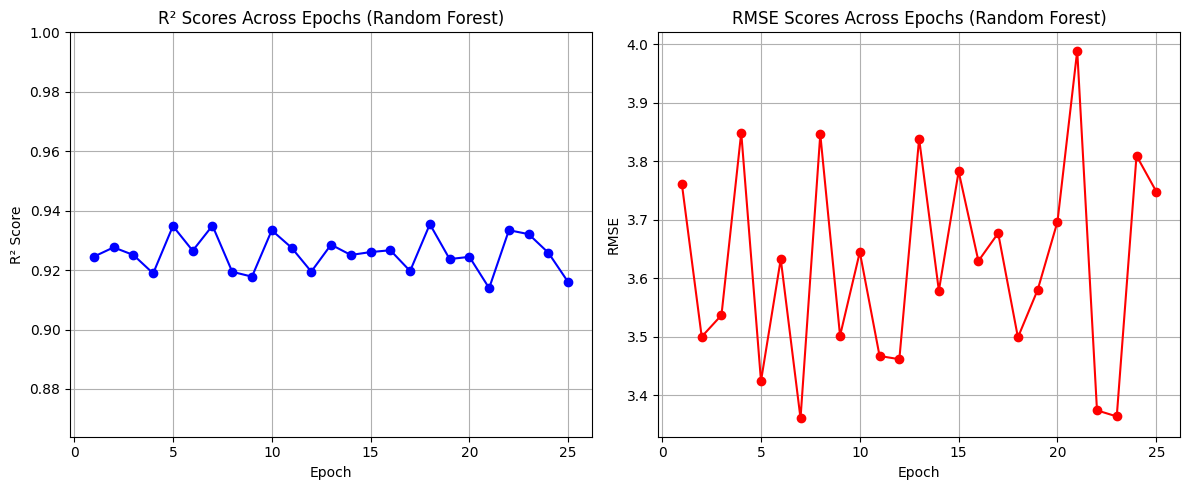

In [10]:
features = ["AQI", "PM2_5", "PM10", "HospitalAdmissions", "O3", "CardiovascularCases"]
target = "HealthImpactScore"

X = df[features].values
y = df[target].values

# Initializing Random Forest model
model = RandomForestRegressor(random_state=42)

#Doing Repeated K-Fold Cross-Validation
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

r2_scores = []
rmse_scores = []

print("Repeated K-Fold Results for Random Forest Regression:")

for epoch, (train_index, test_index) in enumerate(rkf.split(X), start=1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    r2_scores.append(r2)
    rmse_scores.append(rmse)

    print(f"Epoch {epoch}/25: R² = {r2:.4f} | RMSE = {rmse:.4f}")

# Summary to printout
print("\nSummary:")
print(f"R² Mean: {np.mean(r2_scores):.4f} | Std: {np.std(r2_scores):.4f}")
print(f"RMSE Mean: {np.mean(rmse_scores):.4f} | Std: {np.std(rmse_scores):.4f}")

# Results of plotting
epochs = np.arange(1, 26)

plt.figure(figsize=(12, 5))

# Plotting R^2
plt.subplot(1, 2, 1)
plt.plot(epochs, r2_scores, marker='o', linestyle='-', color='b')
plt.title("R² Scores Across Epochs (Random Forest)")
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.grid(True)
plt.ylim([min(r2_scores) - 0.05, 1])

# Plotting RMSE
plt.subplot(1, 2, 2)
plt.plot(epochs, rmse_scores, marker='o', linestyle='-', color='r')
plt.title("RMSE Scores Across Epochs (Random Forest)")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid(True)

plt.tight_layout()
plt.show()


Repeated K-Fold Results for XGBoost Regression:
Epoch 1/25: R² = 0.9211 | RMSE = 3.8448
Epoch 2/25: R² = 0.9217 | RMSE = 3.6421
Epoch 3/25: R² = 0.9191 | RMSE = 3.6750
Epoch 4/25: R² = 0.9115 | RMSE = 4.0218
Epoch 5/25: R² = 0.9244 | RMSE = 3.6887
Epoch 6/25: R² = 0.9200 | RMSE = 3.7906
Epoch 7/25: R² = 0.9284 | RMSE = 3.5255
Epoch 8/25: R² = 0.9153 | RMSE = 3.9432
Epoch 9/25: R² = 0.9136 | RMSE = 3.5893
Epoch 10/25: R² = 0.9313 | RMSE = 3.7007
Epoch 11/25: R² = 0.9167 | RMSE = 3.7177
Epoch 12/25: R² = 0.9114 | RMSE = 3.6322
Epoch 13/25: R² = 0.9270 | RMSE = 3.8802
Epoch 14/25: R² = 0.9219 | RMSE = 3.6538
Epoch 15/25: R² = 0.9187 | RMSE = 3.9655
Epoch 16/25: R² = 0.9120 | RMSE = 3.9774
Epoch 17/25: R² = 0.9107 | RMSE = 3.8781
Epoch 18/25: R² = 0.9258 | RMSE = 3.7504
Epoch 19/25: R² = 0.9143 | RMSE = 3.7944
Epoch 20/25: R² = 0.9227 | RMSE = 3.7390
Epoch 21/25: R² = 0.9090 | RMSE = 4.1022
Epoch 22/25: R² = 0.9304 | RMSE = 3.4497
Epoch 23/25: R² = 0.9243 | RMSE = 3.5509
Epoch 24/25: R² = 

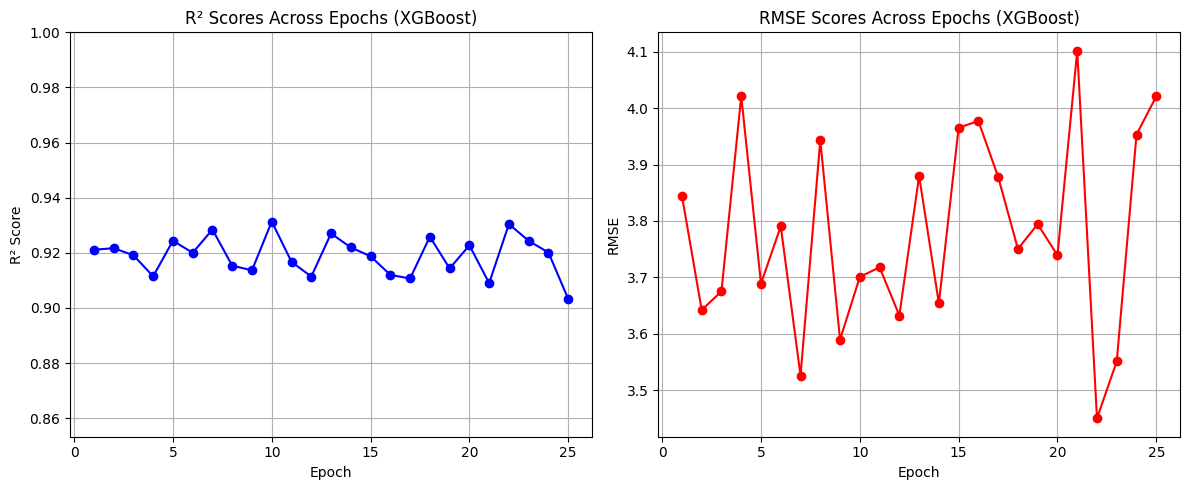

In [11]:
features = ["AQI", "PM2_5", "PM10", "HospitalAdmissions", "O3", "CardiovascularCases"]
target = "HealthImpactScore"

X = df[features].values
y = df[target].values

# Initialize XGBoost model
model = XGBRegressor(random_state=42, verbosity=0)

# Doing the Repeated K-Fold Cross-Validation
rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

r2_scores = []
rmse_scores = []

print("Repeated K-Fold Results for XGBoost Regression:")

for epoch, (train_index, test_index) in enumerate(rkf.split(X), start=1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    r2_scores.append(r2)
    rmse_scores.append(rmse)

    print(f"Epoch {epoch}/25: R² = {r2:.4f} | RMSE = {rmse:.4f}")

# Summary to printout
print("\nSummary:")
print(f"R² Mean: {np.mean(r2_scores):.4f} | Std: {np.std(r2_scores):.4f}")
print(f"RMSE Mean: {np.mean(rmse_scores):.4f} | Std: {np.std(rmse_scores):.4f}")

# Results of Plotting
epochs = np.arange(1, 26)

plt.figure(figsize=(12, 5))

# Ploting R^2
plt.subplot(1, 2, 1)
plt.plot(epochs, r2_scores, marker='o', linestyle='-', color='b')
plt.title("R² Scores Across Epochs (XGBoost)")
plt.xlabel("Epoch")
plt.ylabel("R² Score")
plt.grid(True)
plt.ylim([min(r2_scores) - 0.05, 1])

# Plotting RMSE
plt.subplot(1, 2, 2)
plt.plot(epochs, rmse_scores, marker='o', linestyle='-', color='r')
plt.title("RMSE Scores Across Epochs (XGBoost)")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid(True)

plt.tight_layout()
plt.show()


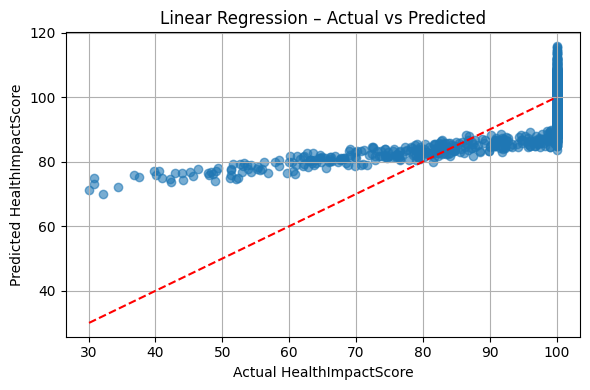

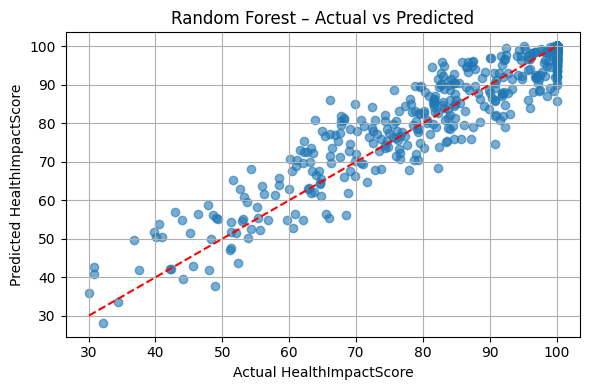

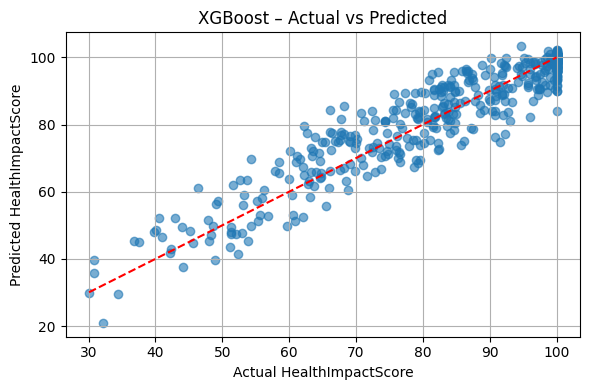

In [12]:
features = ["AQI", "PM2_5", "PM10", "HospitalAdmissions", "O3","CardiovascularCases"]
target = "HealthImpactScore"

X = df[features]
y = df[target]

#Train‑test splitting
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=42)

#Defining tuned models
linear = LinearRegression()

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42)

xgb = XGBRegressor(
    n_estimators=400,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=1.0,
    random_state=42,
    objective='reg:squarederror')

models = {"Linear Regression": linear,"Random Forest": rf,"XGBoost": xgb}

results = []

#Training, predicting, evaluating and plotting
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculating RMSE manually by taking the square root
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)
    results.append({"Model": name, "RMSE": rmse, "R²": r2})

    plt.figure(figsize=(6,4))
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()], '--r')
    plt.title(f"{name} – Actual vs Predicted")
    plt.xlabel("Actual HealthImpactScore")
    plt.ylabel("Predicted HealthImpactScore")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [13]:
features = ["AQI", "PM2_5", "PM10", "HospitalAdmissions", "O3", "CardiovascularCases"]
target = "HealthImpactScore"

X = df[features]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Hyperparameter Grid: Random Forest
rf_model = RandomForestRegressor(random_state=42)

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]}

rf_grid = GridSearchCV(estimator=rf_model,
                       param_grid=rf_param_grid,
                       cv=5,
                       scoring='neg_root_mean_squared_error',
                       verbose=1,
                       n_jobs=-1)

rf_grid.fit(X_train, y_train)

print("Best Random Forest Parameters:", rf_grid.best_params_)

# Evaluating the best RF model
rf_best = rf_grid.best_estimator_
rf_pred = rf_best.predict(X_test)
rf_best_r2 = r2_score(y_test, rf_pred)
rf_best_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
print("RF R²:", rf_best_r2)
print("RF RMSE:", rf_best_rmse)


# Hyperparameter Grid: XGBoost
xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror')

xgb_param_grid = {
    'n_estimators': [100, 300, 400],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]}

xgb_grid = GridSearchCV(estimator=xgb_model,
                        param_grid=xgb_param_grid,
                        cv=5,
                        scoring='neg_root_mean_squared_error',
                        verbose=1,
                        n_jobs=-1)

xgb_grid.fit(X_train, y_train)

print("Best XGBoost Parameters:", xgb_grid.best_params_)

# Evaluating the best XGBoost model
xgb_best = xgb_grid.best_estimator_
xgb_pred = xgb_best.predict(X_test)
xgb_best_r2 = r2_score(y_test, xgb_pred)
xgb_best_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
print("XGB R²:", xgb_best_r2)
print("XGB RMSE:", xgb_best_rmse)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Random Forest Parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
RF R²: 0.926629222891926
RF RMSE: 3.707720129377403
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best XGBoost Parameters: {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
XGB R²: 0.9272399951086864
XGB RMSE: 3.692255491498759


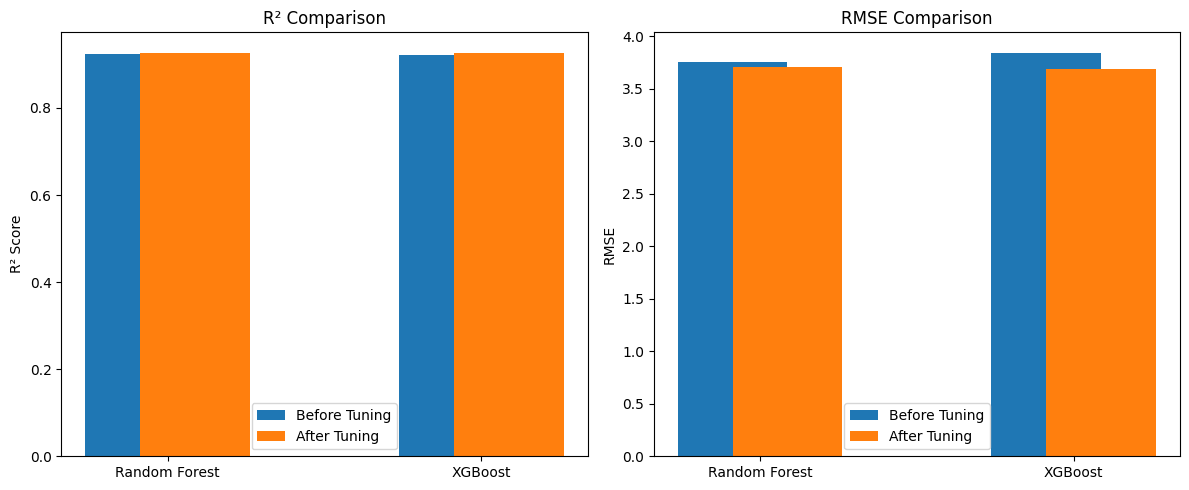

In [14]:
# Before tuning scores from earlier results
r2_before = [0.9247, 0.9211]
rmse_before = [3.7565, 3.8448]

# After tuning scores taken directly from GridSearchCV best models
r2_after = [rf_best_r2, xgb_best_r2]
rmse_after = [rf_best_rmse, xgb_best_rmse]

models = ['Random Forest', 'XGBoost']

x = np.arange(len(models))
width = 0.35
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# R² Plot
axes[0].bar(x - width/4, r2_before, width, label='Before Tuning')
axes[0].bar(x + width/4, r2_after, width, label='After Tuning')
axes[0].set_title("R² Comparison")
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].set_ylabel("R² Score")
axes[0].legend()

# RMSE Plot
axes[1].bar(x - width/4, rmse_before, width, label='Before Tuning')
axes[1].bar(x + width/4, rmse_after, width, label='After Tuning')
axes[1].set_title("RMSE Comparison")
axes[1].set_xticks(x)
axes[1].set_xticklabels(models)
axes[1].set_ylabel("RMSE")
axes[1].legend()

plt.tight_layout()
plt.show()

In [15]:
# Creating a DataFrame for the comparison table
comparison_data = {
    'Model': ['Random Forest', 'XGBoost'],
    'R2 Before Tuning': [0.9247, 0.9211],
    'R2 After Tuning': [rf_best_r2, xgb_best_r2],
    'RMSE Before Tuning': [3.7565, 3.8448],
    'RMSE After Tuning': [rf_best_rmse, xgb_best_rmse]}

comparison_df = pd.DataFrame(comparison_data)

# Displaying the table
display(comparison_df)

,Model,R2 Before Tuning,R2 After Tuning,RMSE Before Tuning,RMSE After Tuning
0,Random Forest,0.9247,0.926629,3.7565,3.707720
1,XGBoost,0.9211,0.927240,3.8448,3.692255


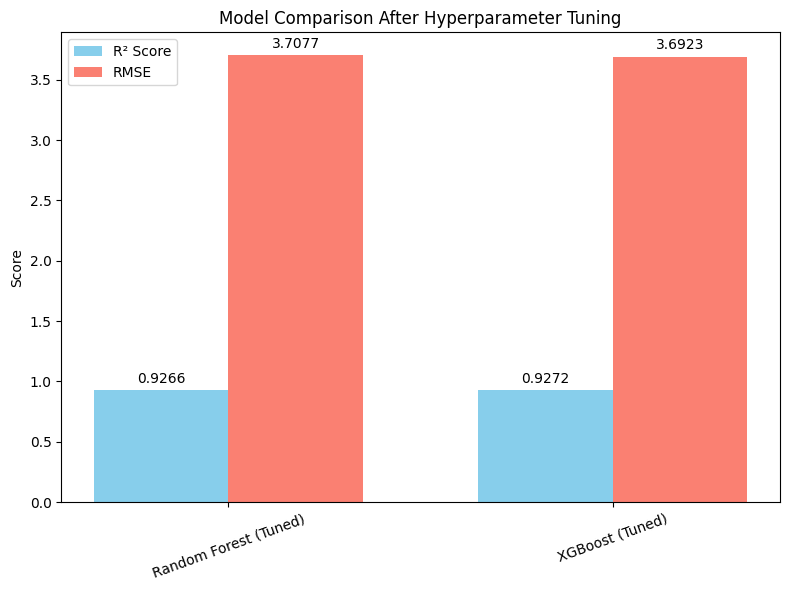

In [16]:
models = ["Random Forest (Tuned)", "XGBoost (Tuned)"]
r2_after = [0.9266, 0.9272]   # Example values
rmse_after = [3.7077, 3.6923]

x = np.arange(len(models))
width = 0.35

fig, ax1 = plt.subplots(figsize=(8,6))

# R² plot
bar1 = ax1.bar(x - width/2, r2_after, width, label="R² Score", color="skyblue")

# RMSE plot
bar2 = ax1.bar(x + width/2, rmse_after, width, label="RMSE", color="salmon")


ax1.set_ylabel("Score")
ax1.set_title("Model Comparison After Hyperparameter Tuning")
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=20)
ax1.legend()

for bar in bar1 + bar2:
    height = bar.get_height()
    ax1.annotate(f"{height:.4f}",
                 xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0,3),
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()

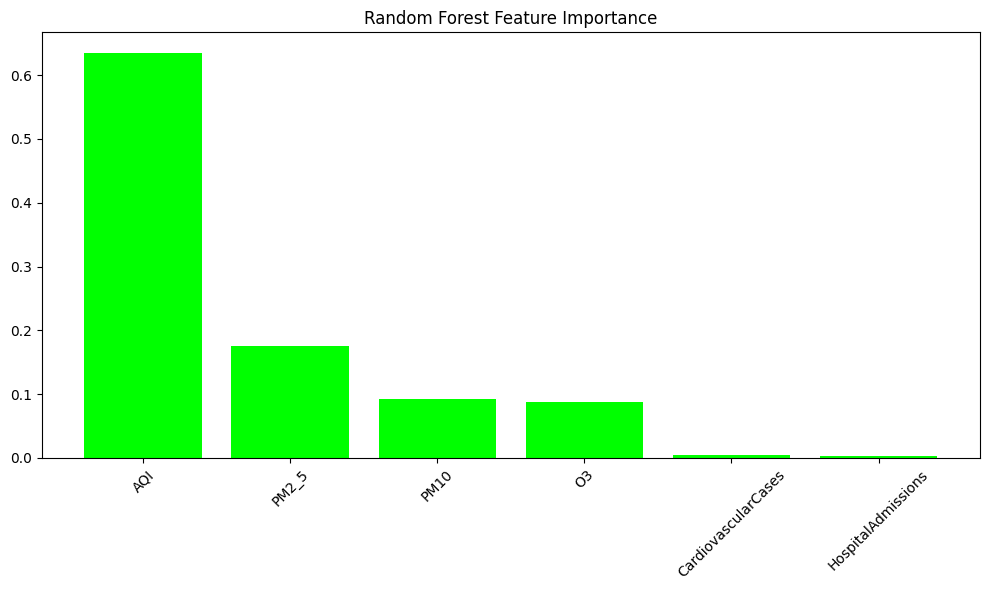

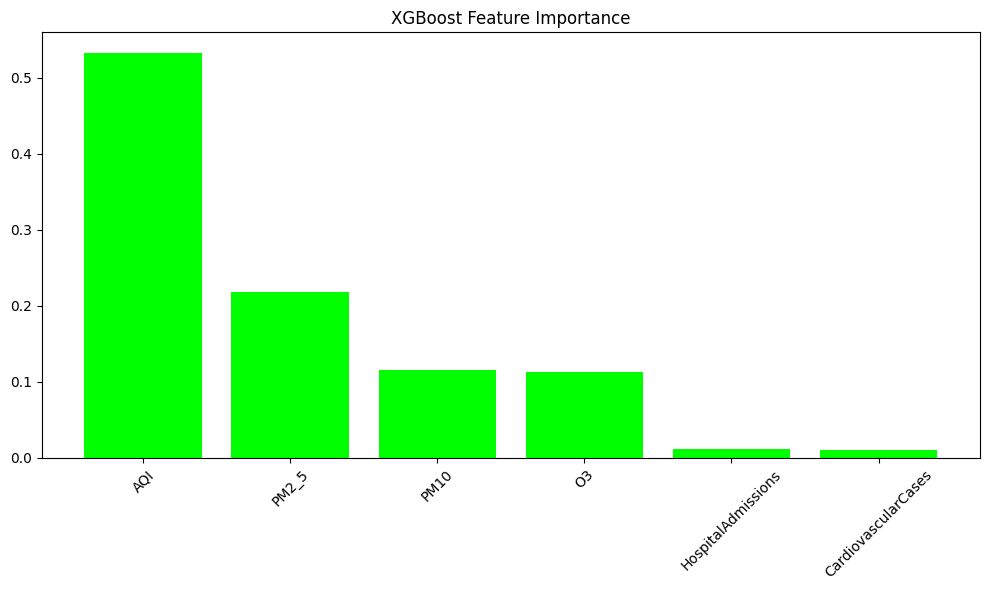

In [17]:
features = ["AQI", "PM2_5", "PM10", "HospitalAdmissions", "O3", "CardiovascularCases"]

# For Random Forest
rf_importances = rf_best.feature_importances_

# For XGBoost
xgb_importances = xgb_best.feature_importances_

#Plot for feature importance
def plot_feature_importance(importances, model_name):
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(10,6))
    plt.title(f"{model_name} Feature Importance")
    plt.bar(range(len(importances)), importances[indices], color="lime", align="center")
    plt.xticks(range(len(importances)), [features[i] for i in indices], rotation=45)
    plt.tight_layout()
    plt.show()

plot_feature_importance(rf_importances, "Random Forest")
plot_feature_importance(xgb_importances, "XGBoost")

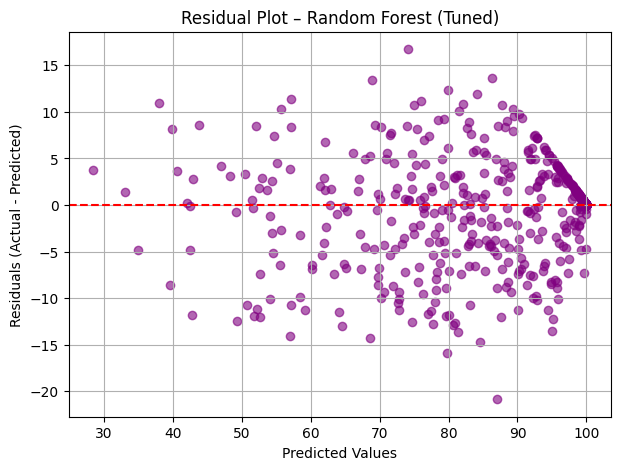

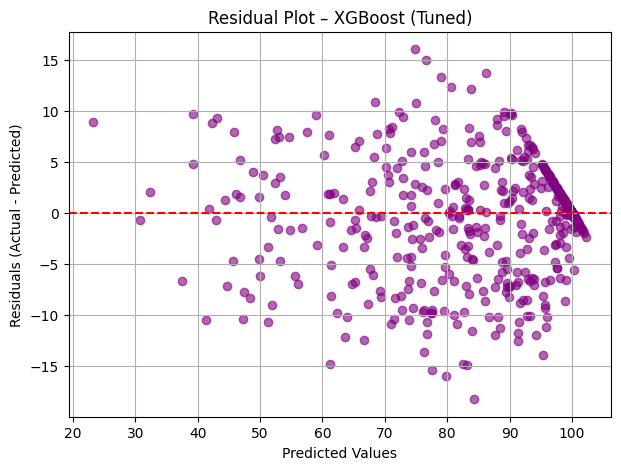

In [18]:
def plot_residuals(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred

    plt.figure(figsize=(7,5))
    plt.scatter(y_pred, residuals, alpha=0.6, color="purple")
    plt.axhline(y=0, color="red", linestyle="--")
    plt.title(f"Residual Plot – {model_name}")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.grid(True)
    plt.show()

plot_residuals(rf_best, X_test, y_test, "Random Forest (Tuned)")
plot_residuals(xgb_best, X_test, y_test, "XGBoost (Tuned)")

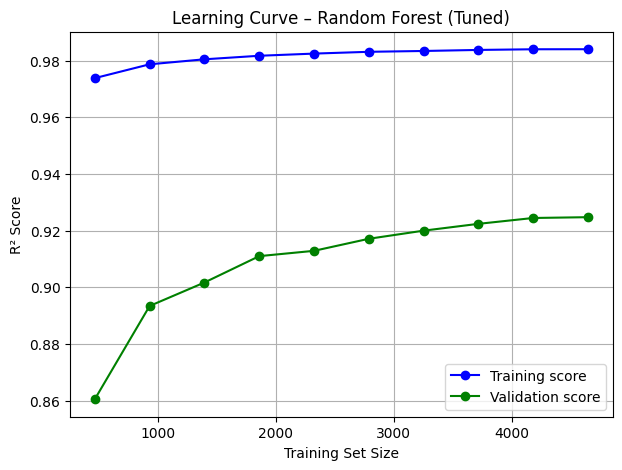

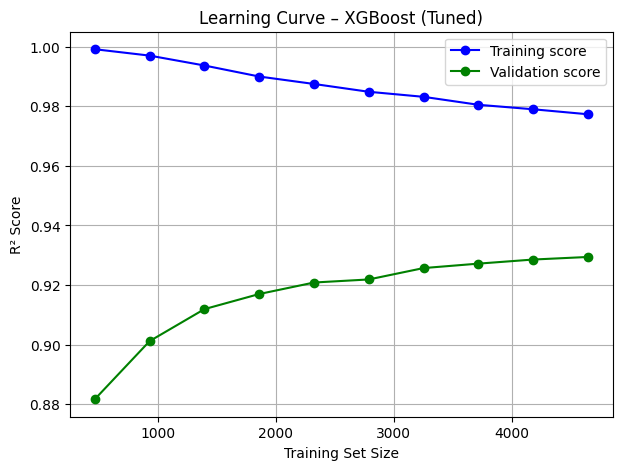

In [19]:
def plot_learning_curve(model, X, y, model_name):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring="r2", n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=42 )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(7,5))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="green", label="Validation score")
    plt.title(f"Learning Curve – {model_name}")
    plt.xlabel("Training Set Size")
    plt.ylabel("R² Score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()


plot_learning_curve(rf_best, X, y, "Random Forest (Tuned)")
plot_learning_curve(xgb_best, X, y, "XGBoost (Tuned)")

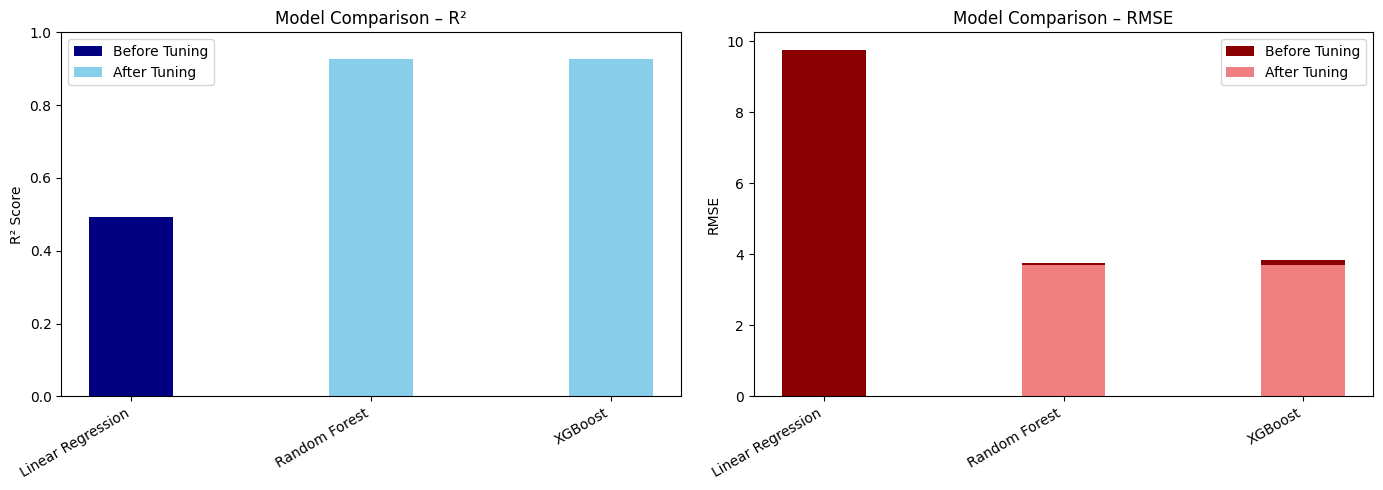

In [20]:
r2_before = [0.4918, 0.9247, 0.9211]
rmse_before = [9.7577, 3.7565, 3.8448]

# After tuning scores
r2_after = [rf_best_r2, xgb_best_r2]   # RF, XGB
rmse_after = [rf_best_rmse, xgb_best_rmse]


# Grouped bar chart
labels = ["Linear Regression", "Random Forest", "XGBoost"]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# R² comparison plot
rects1 = ax[0].bar(x, r2_before, width, label="Before Tuning", color="navy")
rects2 = ax[0].bar(x[1:], r2_after, width, label="After Tuning", color="skyblue")

ax[0].set_ylabel("R² Score")
ax[0].set_title("Model Comparison – R²")
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels, rotation=30, ha="right")
ax[0].set_ylim(0, 1)
ax[0].legend()

# RMSE comparison plot
rects3 = ax[1].bar(x, rmse_before, width, label="Before Tuning", color="darkred")
rects4 = ax[1].bar(x[1:], rmse_after, width, label="After Tuning", color="lightcoral")

ax[1].set_ylabel("RMSE")
ax[1].set_title("Model Comparison – RMSE")
ax[1].set_xticks(x)
ax[1].set_xticklabels(labels, rotation=30, ha="right")
ax[1].legend()

plt.tight_layout()
plt.show()